# Clustering Project Notebook
***

## Zillow: What is driving the errors in the Zestimates?

### Background:

Zillow, a real estate website in the United States, uses a Zestimate to estimate a property's market value.

"The Zestimate® home valuation model is Zillow’s estimate of a home’s market value. A Zestimate incorporates public, MLS and user-submitted data into Zillow’s proprietary formula, also taking into account home facts, location and market trends. It is not an appraisal and can’t be used in place of an appraisal." - zillow.com

For this project, we will look into finding drivers of error in the Zestimate.  Using clustering methodologies, feature identification and comparison, visualizations, statistical testing, and regression models, we are to find drivers of error to predict log error.  


### Project Goals:

- Using Zillow data for single unit/single family homes sold in 2017, find drivers of log error in the Zestimate.

- Create 4 regression models to predict log error

- Use clustering methodologies to help identify drivers of log error

- Deliver findings in a final Jupyter Notebook presentation


## Executive Summary: 

#### Findings Include:


#### Takeaways:


#### Next Steps to Explore Further:

***

# Data Acquisition / Data Preparation / Wrangling

##### Using custom functions in wrangle.py, use an SQl query to pull data from Zillow database joining 7 tables to select only properties sold in 2017 for single unit / single family homes.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

import wrangle_excs as wrangle

# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

In [2]:
df = wrangle.wrangle_zillow()

### Data Acquisition / Prep / Wrangling Takeaways:

- Created and used functions in wrangle.py to acquire and prep data

- Used a SQL query to join 7 tables
- Selected only single family properties filtered by:
    - Properties with propertylandusetypeid = [261, 262, 263, 264, 265, 266, 279]
    - Only retrieving latest transaction date, eliminating duplicates sold more than once in same year
    - Only selecting properties with at least 1 bath & bed and 350 sqft area 
    - Only properties with a latitude and longitude that is not null
    - Dropping columns that are less than 70% populated, mostly empty columns
    - Adding a 'county' column based on FIPS unique county identifier feature
    - Dropping columns that are not useful features or redundant
    - Filling null values in unitcnt column with 1 since all are single unit properties
    - Replacing nulls with median values for select columns: 
        - 7313 for lotsizesquarefeet
        - 6.0 for buildingqualitytypeid
    -Since this is Southern CA, filling null with 'None' for heatingorsystemdesc because most likely don't have one
    -Rename columns for easier readability
    -Removed outliers based on Inter Quartile Rule for properties with outliers in square footage, price, bedrooms, and bathrooms
    



# Explore

In [3]:
# Take a look at the dataframe returned from acquire & prep after wrangling
df.shape

(67490, 26)

In [4]:
df.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips    latitude  \
0        3.5       4.0                    6.0      3100.0  6059.0  33634931.0   
1        1.0       2.0                    6.0      1465.0  6111.0  34449266.0   
2        2.0       3.0                    6.0      1243.0  6059.0  33886168.0   
3        3.0       4.0                    8.0      2376.0  6037.0  34245180.0   
4        3.0       3.0                    8.0      1312.0  6037.0  34185120.0   

     longitude  lotsizesquarefeet  propertylandusetypeid  \
0 -117869207.0             4506.0                  261.0   
1 -119281531.0            12647.0                  261.0   
2 -117823170.0             8432.0                  261.0   
3 -118240722.0            13038.0                  261.0   
4 -118414640.0           278581.0                  266.0   

   rawcensustractandblock  ...  structuretaxvaluedollarcnt  tax_value  \
0            6.059063e+07  ...                    485713.0  1023282.0   
1            6.111001e+07  ...                     88000.0   464000.0   
2            6.059022e+07  ...                     85289.0   564778.0   
3            6.037300e+07  ...                    108918.0   145143.0   
4            6.037124e+07  ...                     73681.0   119407.0   

   assessmentyear  landtaxvaluedollarcnt  taxamount  logerror  \
0          2016.0               537569.0   11013.72  0.025595   
1          2016.0               376000.0    5672.48  0.055619   
2          2016.0               479489.0    6488.30  0.005383   
3          2016.0                36225.0    1777.51 -0.103410   
4          2016.0                45726.0    1533.89  0.006940   

   transactiondate  heatingorsystemdesc        propertylandusedesc  \
0       2017-01-01                 None  Single Family Residential   
1       2017-01-01                 None  Single Family Residential   
2       2017-01-01                 None  Single Family Residential   
3       2017-01-01              Central  Single Family Residential   
4       2017-01-01              Central                Condominium   

        county  
0       Orange  
1      Ventura  
2       Orange  
3  Los Angeles  
4  Los Angeles  

[5 rows x 26 columns]

In [5]:
#Check to see if nulls were removed
wrangle.nulls_by_col(df)

num_rows_missing  percent_rows_missing
bathrooms                                  0                   0.0
bedrooms                                   0                   0.0
buildingqualitytypeid                      0                   0.0
sq_footage                                 0                   0.0
fips                                       0                   0.0
latitude                                   0                   0.0
longitude                                  0                   0.0
lotsizesquarefeet                          0                   0.0
propertylandusetypeid                      0                   0.0
rawcensustractandblock                     0                   0.0
regionidcity                               0                   0.0
regionidcounty                             0                   0.0
regionidzip                                0                   0.0
roomcnt                                    0                   0.0
unitcnt                                    0                   0.0
yr_built                                   0                   0.0
structuretaxvaluedollarcnt                 0                   0.0
tax_value                                  0                   0.0
assessmentyear                             0                   0.0
landtaxvaluedollarcnt                      0                   0.0
taxamount                                  0                   0.0
logerror                                   0                   0.0
transactiondate                            0                   0.0
heatingorsystemdesc                        0                   0.0
propertylandusedesc                        0                   0.0
county                                     0                   0.0

In [6]:
wrangle.nulls_by_row(df)

num_cols_missing percent_cols_missing  index
0                0                  0.0  67490

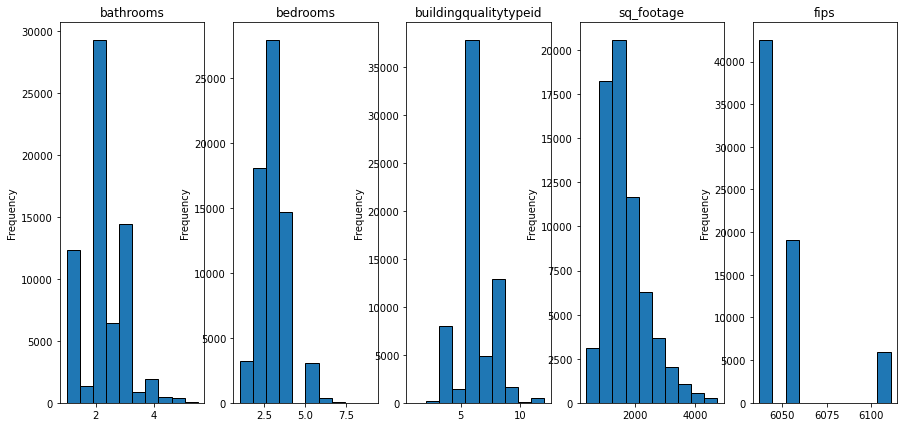

In [7]:
# Plot the distribution of some numeric variables
fig, axs = plt.subplots(1, 5, figsize=(15, 7))

for ax, col in zip(axs, df.select_dtypes('number')):
    df[col].plot.hist(ax=ax, title=col, ec='black')

In [8]:
# Most properties look to have about 3 bedrooms, 2 baths and be less than 2000 sq ft

In [9]:
#Binning square footage for comparison and visualization purposes
df['sq_footage_bins'] = pd.cut(df.sq_footage, [0, 1000, 2000,3000,4000, 10000])
df.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips    latitude  \
0        3.5       4.0                    6.0      3100.0  6059.0  33634931.0   
1        1.0       2.0                    6.0      1465.0  6111.0  34449266.0   
2        2.0       3.0                    6.0      1243.0  6059.0  33886168.0   
3        3.0       4.0                    8.0      2376.0  6037.0  34245180.0   
4        3.0       3.0                    8.0      1312.0  6037.0  34185120.0   

     longitude  lotsizesquarefeet  propertylandusetypeid  \
0 -117869207.0             4506.0                  261.0   
1 -119281531.0            12647.0                  261.0   
2 -117823170.0             8432.0                  261.0   
3 -118240722.0            13038.0                  261.0   
4 -118414640.0           278581.0                  266.0   

   rawcensustractandblock  ...  tax_value  assessmentyear  \
0            6.059063e+07  ...  1023282.0          2016.0   
1            6.111001e+07  ...   464000.0          2016.0   
2            6.059022e+07  ...   564778.0          2016.0   
3            6.037300e+07  ...   145143.0          2016.0   
4            6.037124e+07  ...   119407.0          2016.0   

   landtaxvaluedollarcnt  taxamount  logerror  transactiondate  \
0               537569.0   11013.72  0.025595       2017-01-01   
1               376000.0    5672.48  0.055619       2017-01-01   
2               479489.0    6488.30  0.005383       2017-01-01   
3                36225.0    1777.51 -0.103410       2017-01-01   
4                45726.0    1533.89  0.006940       2017-01-01   

   heatingorsystemdesc        propertylandusedesc       county  \
0                 None  Single Family Residential       Orange   
1                 None  Single Family Residential      Ventura   
2                 None  Single Family Residential       Orange   
3              Central  Single Family Residential  Los Angeles   
4              Central                Condominium  Los Angeles   

   sq_footage_bins  
0     (3000, 4000]  
1     (1000, 2000]  
2     (1000, 2000]  
3     (2000, 3000]  
4     (1000, 2000]  

[5 rows x 27 columns]

In [10]:
df['transactiondate'] = pd.to_datetime(df['transactiondate'])
df['month'] = pd.DatetimeIndex(df['transactiondate']).month
df.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips    latitude  \
0        3.5       4.0                    6.0      3100.0  6059.0  33634931.0   
1        1.0       2.0                    6.0      1465.0  6111.0  34449266.0   
2        2.0       3.0                    6.0      1243.0  6059.0  33886168.0   
3        3.0       4.0                    8.0      2376.0  6037.0  34245180.0   
4        3.0       3.0                    8.0      1312.0  6037.0  34185120.0   

     longitude  lotsizesquarefeet  propertylandusetypeid  \
0 -117869207.0             4506.0                  261.0   
1 -119281531.0            12647.0                  261.0   
2 -117823170.0             8432.0                  261.0   
3 -118240722.0            13038.0                  261.0   
4 -118414640.0           278581.0                  266.0   

   rawcensustractandblock  ...  assessmentyear  landtaxvaluedollarcnt  \
0            6.059063e+07  ...          2016.0               537569.0   
1            6.111001e+07  ...          2016.0               376000.0   
2            6.059022e+07  ...          2016.0               479489.0   
3            6.037300e+07  ...          2016.0                36225.0   
4            6.037124e+07  ...          2016.0                45726.0   

   taxamount  logerror  transactiondate  heatingorsystemdesc  \
0   11013.72  0.025595       2017-01-01                 None   
1    5672.48  0.055619       2017-01-01                 None   
2    6488.30  0.005383       2017-01-01                 None   
3    1777.51 -0.103410       2017-01-01              Central   
4    1533.89  0.006940       2017-01-01              Central   

         propertylandusedesc       county  sq_footage_bins  month  
0  Single Family Residential       Orange     (3000, 4000]      1  
1  Single Family Residential      Ventura     (1000, 2000]      1  
2  Single Family Residential       Orange     (1000, 2000]      1  
3  Single Family Residential  Los Angeles     (2000, 3000]      1  
4                Condominium  Los Angeles     (1000, 2000]      1  

[5 rows x 28 columns]

In [11]:
#Binning transactiondate for comparison and visualization purposes
df['month_bins'] = pd.cut(df.month, [0,3,6,9,12])
df.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips    latitude  \
0        3.5       4.0                    6.0      3100.0  6059.0  33634931.0   
1        1.0       2.0                    6.0      1465.0  6111.0  34449266.0   
2        2.0       3.0                    6.0      1243.0  6059.0  33886168.0   
3        3.0       4.0                    8.0      2376.0  6037.0  34245180.0   
4        3.0       3.0                    8.0      1312.0  6037.0  34185120.0   

     longitude  lotsizesquarefeet  propertylandusetypeid  \
0 -117869207.0             4506.0                  261.0   
1 -119281531.0            12647.0                  261.0   
2 -117823170.0             8432.0                  261.0   
3 -118240722.0            13038.0                  261.0   
4 -118414640.0           278581.0                  266.0   

   rawcensustractandblock  ...  landtaxvaluedollarcnt  taxamount  logerror  \
0            6.059063e+07  ...               537569.0   11013.72  0.025595   
1            6.111001e+07  ...               376000.0    5672.48  0.055619   
2            6.059022e+07  ...               479489.0    6488.30  0.005383   
3            6.037300e+07  ...                36225.0    1777.51 -0.103410   
4            6.037124e+07  ...                45726.0    1533.89  0.006940   

   transactiondate  heatingorsystemdesc        propertylandusedesc  \
0       2017-01-01                 None  Single Family Residential   
1       2017-01-01                 None  Single Family Residential   
2       2017-01-01                 None  Single Family Residential   
3       2017-01-01              Central  Single Family Residential   
4       2017-01-01              Central                Condominium   

        county  sq_footage_bins  month  month_bins  
0       Orange     (3000, 4000]      1      (0, 3]  
1      Ventura     (1000, 2000]      1      (0, 3]  
2       Orange     (1000, 2000]      1      (0, 3]  
3  Los Angeles     (2000, 3000]      1      (0, 3]  
4  Los Angeles     (1000, 2000]      1      (0, 3]  

[5 rows x 29 columns]

(-4.0, 4.0)

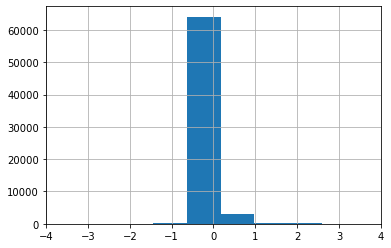

In [12]:
#Look at logerror
df.logerror.hist()
plt.xlim(-4, 4)

In [13]:
df.logerror.max(), df.logerror.min(), df.logerror.mean(), df.logerror.median()

(3.39454406516, -4.65542037764, 0.016190522976922635, 0.00618658543751)

In [14]:
#Log error seems to be normally distributed with most centered around 0

### Before exploring data further, will need to split data into train, validate and test so that we only explore on train.

In [15]:
train, validate, test = wrangle.train_validate_test_split(df)
train.shape, validate.shape, test.shape

((40494, 29), (13498, 29), (13498, 29))

In [16]:
#Let's look at how variables are correlated
corr =  train.corr(method='pearson')

<AxesSubplot:>

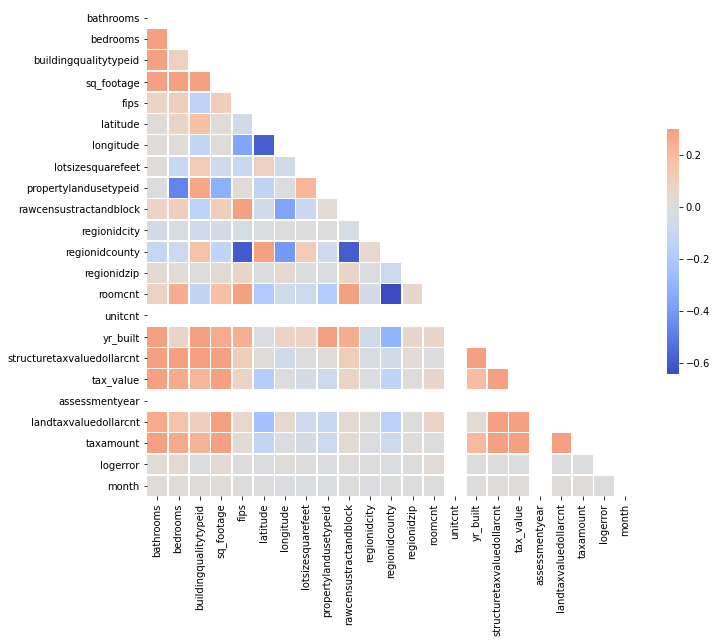

In [17]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

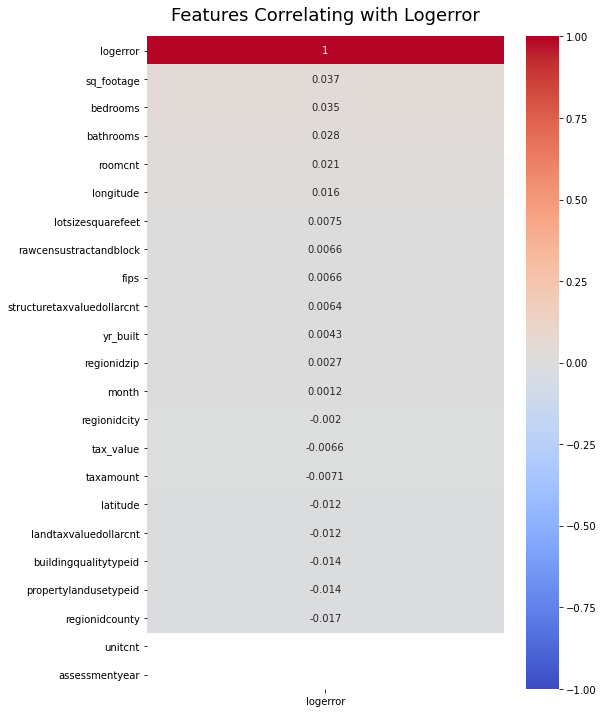

In [18]:
#see what correlates most with logerror with heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16);

In [19]:
#Look at the correlation with log error
corr_log = train.corrwith(train["logerror"])
corr_log.max

<bound method NDFrame._add_numeric_operations.<locals>.max of bathrooms                     0.027558
bedrooms                      0.035392
buildingqualitytypeid        -0.013531
sq_footage                    0.036798
fips                          0.006574
latitude                     -0.011984
longitude                     0.015879
lotsizesquarefeet             0.007544
propertylandusetypeid        -0.013906
rawcensustractandblock        0.006598
regionidcity                 -0.002021
regionidcounty               -0.017465
regionidzip                   0.002730
roomcnt                       0.020787
unitcnt                            NaN
yr_built                      0.004309
structuretaxvaluedollarcnt    0.006424
tax_value                    -0.006590
assessmentyear                     NaN
landtaxvaluedollarcnt        -0.012332
taxamount                    -0.007145
logerror                      1.000000
month                         0.001169
dtype: float64>

In [20]:
print(corr_log.sort_values(ascending=False))

logerror                      1.000000
sq_footage                    0.036798
bedrooms                      0.035392
bathrooms                     0.027558
roomcnt                       0.020787
longitude                     0.015879
lotsizesquarefeet             0.007544
rawcensustractandblock        0.006598
fips                          0.006574
structuretaxvaluedollarcnt    0.006424
yr_built                      0.004309
regionidzip                   0.002730
month                         0.001169
regionidcity                 -0.002021
tax_value                    -0.006590
taxamount                    -0.007145
latitude                     -0.011984
landtaxvaluedollarcnt        -0.012332
buildingqualitytypeid        -0.013531
propertylandusetypeid        -0.013906
regionidcounty               -0.017465
unitcnt                            NaN
assessmentyear                     NaN
dtype: float64


In [21]:
#When looking at correlation with log error, square footage, bedrooms, and bathrooms rank highest.

### Question 1.  Does log error differ across square feet?

<AxesSubplot:>

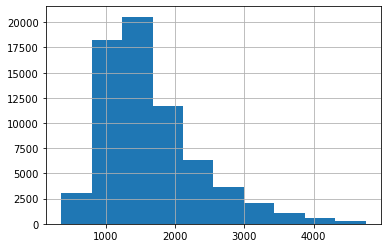

In [22]:
#Let's look at the distribution of square footage first
df.sq_footage.hist()

In [23]:
#Looks normally distributed with a right skew

<AxesSubplot:title={'center':'Is there a relationship between logerror and square feet?'}, xlabel='logerror', ylabel='sq_footage'>

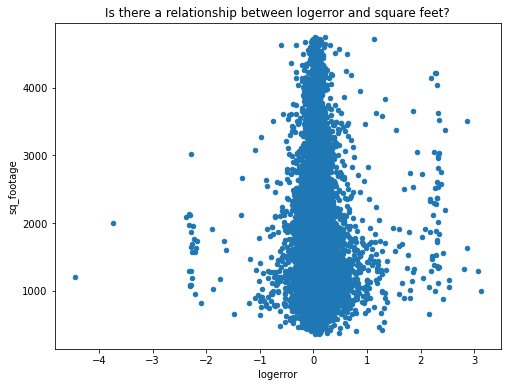

In [24]:
#Let's look at the relationship between log error and square feet
train.plot.scatter(
    x="logerror",
    y="sq_footage",
    title='Is there a relationship between logerror and square feet?',
    figsize=(8, 6),
)

In [25]:
#Log error seems to be centered at 0 for the most part, but does appear to have some outlier bands and scattering 
#between -2 and -3 and thru 2 and 3.   

<AxesSubplot:title={'center':'Distribution of sq_footage_bin'}>

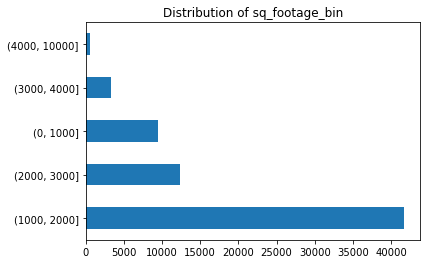

In [26]:
# What about comparing amongst square footage? 

#Let's look at the distribution of square footage by bins

df.sq_footage_bins.value_counts().plot.barh(title='Distribution of sq_footage_bin')

In [27]:
#Looks like most properties are between 1,000-2,000 square feet

<AxesSubplot:xlabel='sq_footage_bins', ylabel='logerror'>

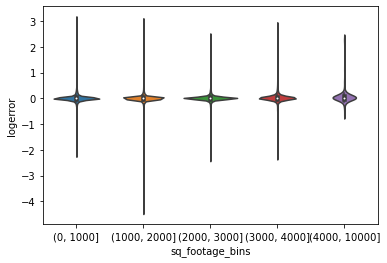

In [28]:
#Let's look at how log error compares across square footage by bins
sns.violinplot(data=train, y='logerror', x='sq_footage_bins')

In [29]:
#It doesn't look like there's much variance in log error between square footage

### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance between the square footage

$H_a$: there is a difference in logerror variance between the square footage

In [30]:
stats.levene(
    train[train.sq_footage <= 1000].logerror,
    train[train.sq_footage > 1000].logerror,
)

LeveneResult(statistic=26.421381823118583, pvalue=2.7575885155652377e-07)

In [31]:
stats.levene(
    train[train.sq_footage <= 2000].logerror,
    train[train.sq_footage > 2000].logerror,
)

LeveneResult(statistic=0.9133570477417297, pvalue=0.339230966900938)

In [32]:
stats.levene(
    train[train.sq_footage <= 3000].logerror,
    train[train.sq_footage > 3000].logerror,
)

LeveneResult(statistic=33.21175253136165, pvalue=8.32476642871702e-09)

In [33]:
stats.levene(
    train[train.sq_footage <= 4000].logerror,
    train[train.sq_footage > 4000].logerror,
)

LeveneResult(statistic=26.208966386291532, pvalue=3.077963100113169e-07)

#### Conclusion:
We reject the null hypothesis that the variance in logerror is the same for all square footages.
The variance is not equal.

### Create independent statistical tests to check for dependency amongst variables

In [34]:
stats.ttest_ind(
    train[train.sq_footage <= 1000].logerror,
    train[train.sq_footage > 1000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-1.1795354395250444, pvalue=0.23822231653253545)

In [35]:
stats.ttest_ind(
    train[train.sq_footage <= 2000].logerror,
    train[train.sq_footage > 2000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-5.468852786673966, pvalue=4.6028033991275334e-08)

In [36]:
stats.ttest_ind(
    train[train.sq_footage <= 3000].logerror,
    train[train.sq_footage > 3000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-5.288640220586799, pvalue=1.3446342217119166e-07)

In [37]:
stats.ttest_ind(
    train[train.sq_footage <= 4000].logerror,
    train[train.sq_footage > 4000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-3.2396298227168385, pvalue=0.0013143037052781863)

### Conclusion:
We reject the null hypothesis that the logerror is the same for square footages above 1000 square feet.

### Question 2. Does  log error differ across county?

In [38]:
#Look at how counties compare in number
df.county.value_counts()

Los Angeles    42474
Orange         19108
Ventura         5908
Name: county, dtype: int64

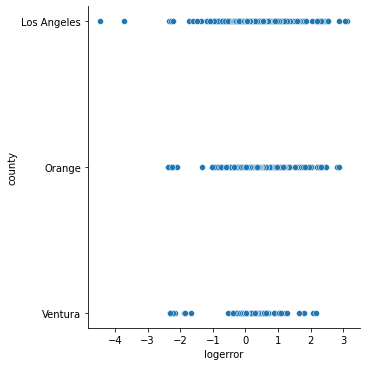

In [39]:
#Look at how log error compares amongst counties
sns.relplot(data=train, x='logerror', y='county')

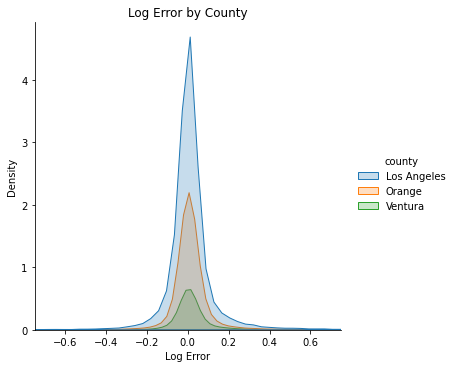

In [40]:
#Plotting distribution of log error by county

sns.displot(train, x='logerror', hue='county', kind='kde', fill=True)
plt.title('Log Error by County')
plt.xlabel('Log Error')
plt.xlim(-0.75, 0.75)
plt.show()

#### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance between the counties
 
𝐻𝑎 : there is a difference in logerror variance between the counties

In [41]:
stats.levene(
    train[train.county == 'Los Angeles'].logerror,
    train[train.county != 'Los Angeles'].logerror,
)

LeveneResult(statistic=25.420357603593807, pvalue=4.630126029827358e-07)

In [42]:
stats.levene(
    train[train.county == 'Ventura'].logerror,
    train[train.county != 'Ventura'].logerror,
)

LeveneResult(statistic=13.435255590635176, pvalue=0.0002472547032054955)

In [43]:
stats.levene(
    train[train.county == 'Orange'].logerror,
    train[train.county != 'Orange'].logerror,
)

LeveneResult(statistic=9.66021727850087, pvalue=0.0018843171405163632)

### Conclusion:
We reject the null hypothesis that the variance in logerror is the same for all counties.
The variance is not equal.

In [44]:
#Running a T-Test to check if county is independent of log error
stats.ttest_ind(
    df.query('county == "Los Angeles"').logerror,
    df.query('county == "Orange"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-3.690124587002322, pvalue=0.0002245156221965261)

In [45]:
stats.ttest_ind(
    df.query('county == "Ventura"').logerror,
    df.query('county == "Orange"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-2.0580613382754938, pvalue=0.03960587164470629)

In [46]:
stats.ttest_ind(
    df.query('county == "Los Angeles"').logerror,
    df.query('county == "Ventura"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-0.38916233430025177, pvalue=0.6971666541218813)

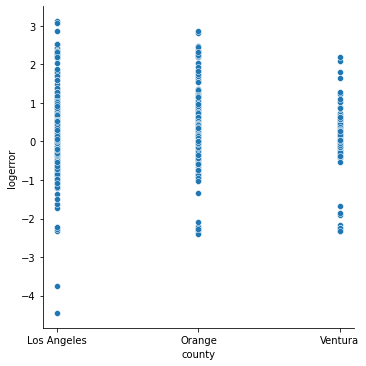

In [47]:
sns.relplot(data=train, y='logerror', x='county')

### Conclusion:
We reject the null hypothesis that the logerror is the same for all counties.

### Question 3.  If we control for month, does log error differ across county?
1. Viz logerror by county for each month bin

2. Analyze each month bin separately

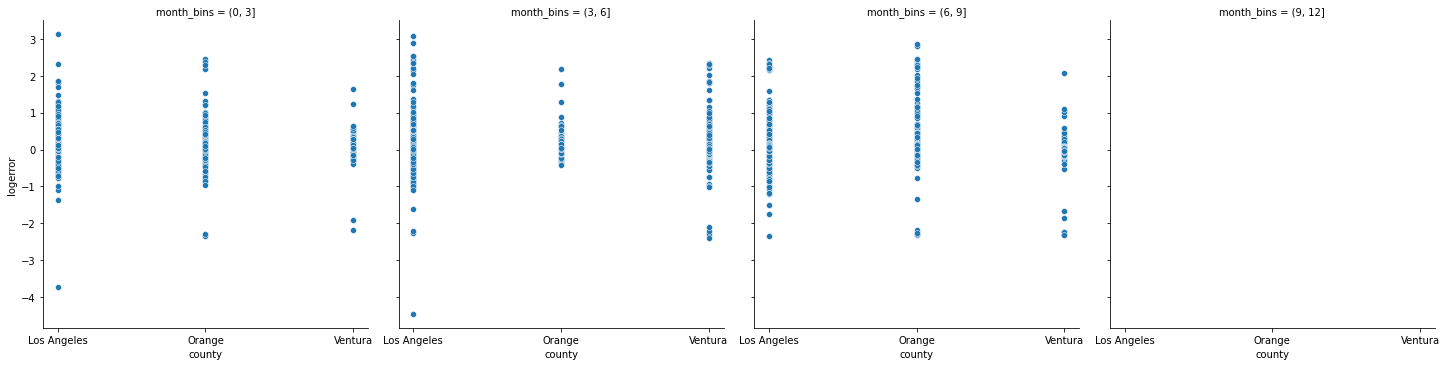

In [48]:
sns.relplot(data=train, y='logerror', x='county', col='month_bins')

In [49]:
# Logerror does not seem to vary much by month or county

Text(0.5, 1.0, 'Does county acccount for upper vs lower\nlogerror in square footage for sales before July?')

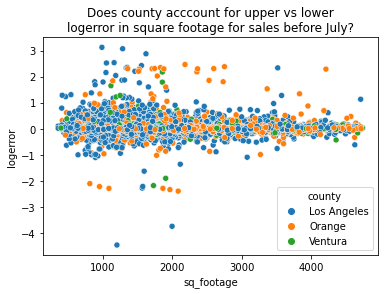

In [50]:
sns.scatterplot(
    x='sq_footage',
    y='logerror',
    data=train[train.month <= 6],
    hue='county',
)
plt.title("Does county acccount for upper vs lower\nlogerror in square footage for sales before July?")

In [51]:
# For sales before July 1st, log error may be grouped by county where Orange County and LA County have higher errors.

Text(0.5, 1.0, 'Does county account for upper vs lower\n logerror in the square footage?')

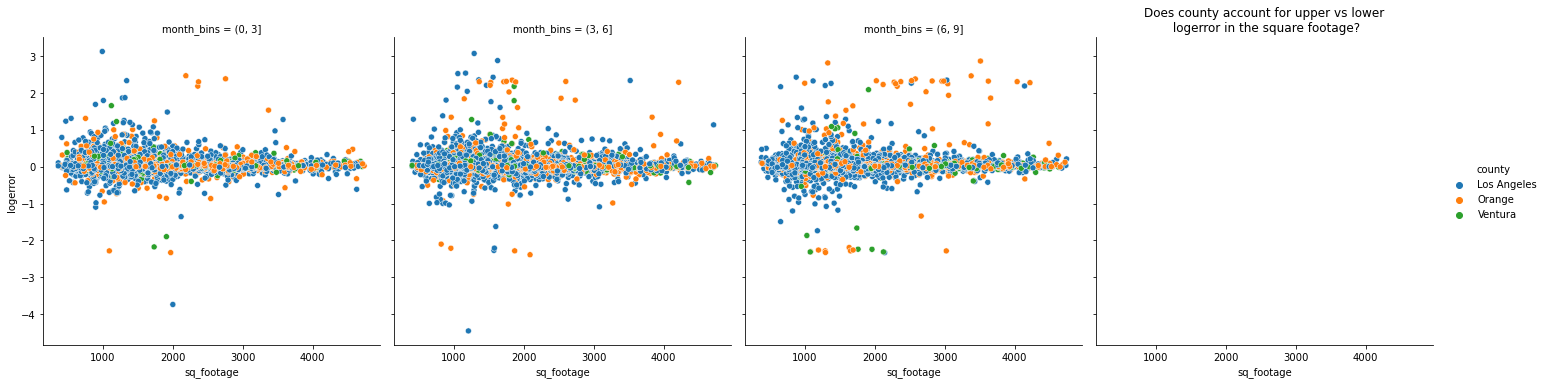

In [52]:
sns.relplot(
    x='sq_footage',
    y='logerror',
    data=train,
    hue='county',
    col='month_bins',
)
plt.title("Does county account for upper vs lower\n logerror in the square footage?")

In [53]:
# Orange County seems to have higher log errors compared to the other counties, 
#especially during the months of June-Sept.  Los Angeles couny looks to have more variance in error, being more 
#scattered on both sides of 0. 


Text(0.5, 1.0, 'Does county account for upper vs lower\n logerror in the square footage?')

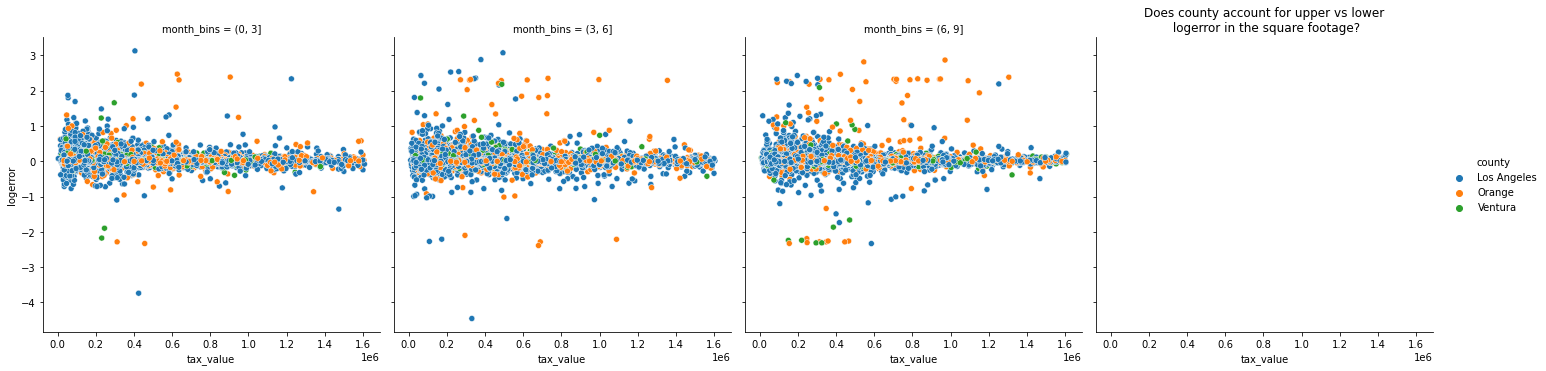

In [54]:
sns.relplot(
    x='tax_value',
    y='logerror',
    data=train,
    hue='county',
    col='month_bins',
)
plt.title("Does county account for upper vs lower\n logerror in the square footage?")

In [55]:
#Comparing using tax value, Orange County still seems to have the highest log errors, especially during June-Sept

Text(0.5, 1.0, 'Does county account for upper vs lower\n log error when looking at the price of property?')

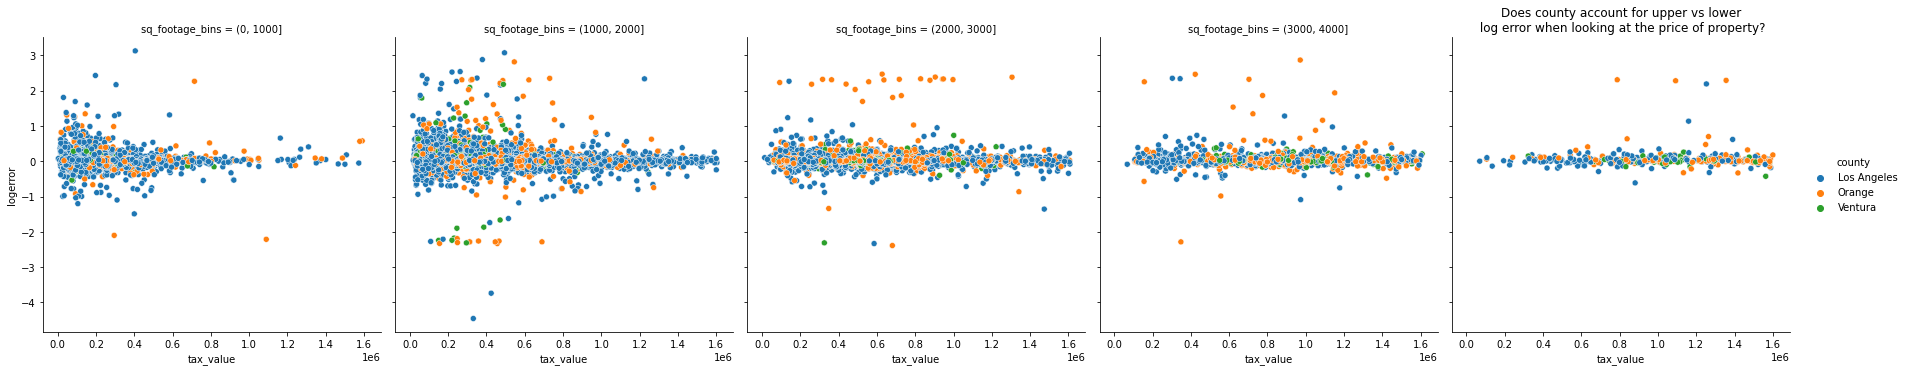

In [56]:
sns.relplot(
    x='tax_value',
    y='logerror',
    data=train,
    hue='county',
    col='sq_footage_bins',
)

plt.title("Does county account for upper vs lower\n log error when looking at the price of property?")

In [57]:
#Comparing using tax value, Orange County accounts for most of the upper band seen in the log error (higher log error)
# especially for homes between 2,000-3,000 square feet.

In [58]:
# Overall, county does seem to be grouped together for certain months and certain square footage

### Question 4: Does log error differ for different number of bedrooms?

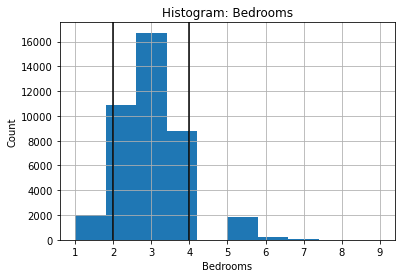

In [59]:
ax = train.bedrooms.hist()
plt.title('Histogram: Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
ax.axvline(2, color='black')
ax.axvline(4, color='black')



<AxesSubplot:title={'center':'Is there a relationship between log error and bedrooms?'}, xlabel='bedrooms', ylabel='logerror'>

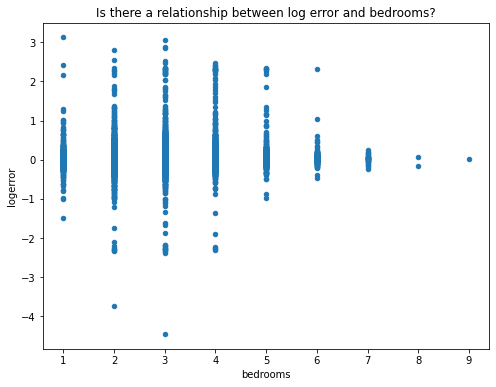

In [60]:
train.plot.scatter(
    y="logerror",
    x="bedrooms",
    title='Is there a relationship between log error and bedrooms?',
    figsize=(8, 6),
)

<AxesSubplot:xlabel='bedrooms', ylabel='logerror'>

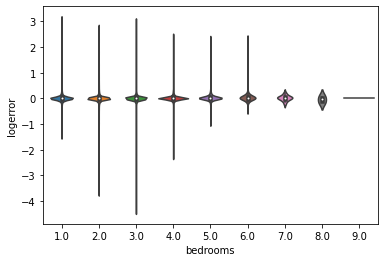

In [61]:
sns.violinplot(data=train, y='logerror', x='bedrooms')

### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance for different number of bedrooms

$H_a$: there is a difference in logerror variance different number of bedrooms

In [62]:
stats.levene(
    train[train.bedrooms <= 4].logerror,
    train[train.bedrooms > 4].logerror,
)

LeveneResult(statistic=2.904900983870122, pvalue=0.08831834834159476)

In [63]:
# We fail to reject the null hypothesis that there is no difference in logerror variance for different number of bedrooms.
#The variance is equal

### Is the log error the same for properties with  4 or less as those with more than 4 bedrooms?

$H_0$ : The logerror is the same for properties with 4 bedrooms or less as with those with more than 4 bedrooms.

$H_a$ : The logerror is not the same for properties with 4 bedrooms or less as with those with more than 4 bedrooms.

In [64]:
stats.ttest_ind(
   train[train.bedrooms <= 4].logerror,
    train[train.bedrooms > 4].logerror,
    equal_var=True,
)

Ttest_indResult(statistic=-6.256198579620443, pvalue=3.984111118952614e-10)

### Conclusion:
We reject the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with more than 4 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with more than  bedrooms.

Text(0.5, 1.0, 'Does log error depend on number of bedrooms?')

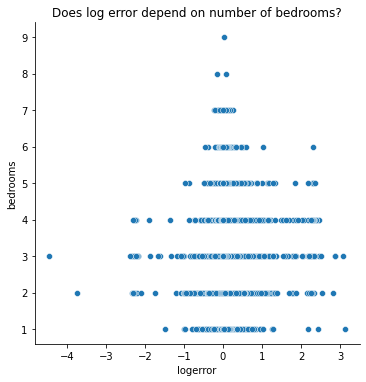

In [65]:
sns.relplot(
    y='bedrooms',
    x='logerror',
    data=train,
)
plt.title("Does log error depend on number of bedrooms?")

## Clustering 


#### Use Clustering to Identify Possible Features of Interest

- Not having any features indicating location near the coast, will look at latitude and longitude features
  to see if we can create a possible feature of interest for modeling and predicting

### Clustering Model #1:

In [66]:
# Choose two features to create possible cluster

In [67]:
# define independent variables for k-means

X = train[['latitude', 'longitude']]
scaler = MinMaxScaler().fit(X)
X_scaled_lat_long = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
# sklearn implementation of KMeans

#define the thing and create 3 clusters
kmeans = KMeans(n_clusters=3, random_state=321)

# fit the thing
kmeans.fit(X_scaled_lat_long )

# Use (predict using) the thing 
kmeans.predict(X_scaled_lat_long )
train['cluster'] = kmeans.predict(X_scaled_lat_long )

X_scaled_lat_long['cluster'] = kmeans.predict(X_scaled_lat_long )

# look at the dataframe
X_scaled_lat_long.head()

latitude  longitude  cluster
6378   0.567793   0.505918        1
65133  0.813725   0.749193        1
45602  0.329705   0.633233        2
75623  0.307416   0.739228        2
71792  0.629328   0.355861        1

In [68]:
#Save this clustering for use in independence testing and possible modeling
train['cluster_lat_long'] = train['cluster']

#Check to see if it was created
train.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips  \
6378         1.0       3.0                    4.0      1368.0  6037.0   
65133        2.0       4.0                    8.0      2381.0  6037.0   
45602        2.0       3.0                    6.0      1810.0  6037.0   
75623        2.0       4.0                    6.0      1558.0  6059.0   
71792        2.0       4.0                    6.0      1769.0  6111.0   

         latitude    longitude  lotsizesquarefeet  propertylandusetypeid  \
6378   34174813.0 -118512540.0             5899.0                  261.0   
65133  34536607.0 -118049605.0            39349.0                  261.0   
45602  33824560.0 -118270268.0             5604.0                  261.0   
75623  33791770.0 -118068568.0             8255.0                  261.0   
71792  34265339.0 -118798087.0             8090.0                  261.0   

       rawcensustractandblock  ...  logerror  transactiondate  \
6378             6.037139e+07  ...  0.211513       2017-01-30   
65133            6.037911e+07  ...  0.018574       2017-08-10   
45602            6.037544e+07  ...  0.017428       2017-06-13   
75623            6.059110e+07  ...  0.037663       2017-09-12   
71792            6.111008e+07  ...  0.029618       2017-08-30   

       heatingorsystemdesc        propertylandusedesc       county  \
6378            Floor/Wall  Single Family Residential  Los Angeles   
65133              Central  Single Family Residential  Los Angeles   
45602           Floor/Wall  Single Family Residential  Los Angeles   
75623                 None  Single Family Residential       Orange   
71792                 None  Single Family Residential      Ventura   

       sq_footage_bins  month  month_bins  cluster  cluster_lat_long  
6378      (1000, 2000]      1      (0, 3]        1                 1  
65133     (2000, 3000]      8      (6, 9]        1                 1  
45602     (1000, 2000]      6      (3, 6]        2                 2  
75623     (1000, 2000]      9      (6, 9]        2                 2  
71792     (1000, 2000]      8      (6, 9]        1                 1  

[5 rows x 31 columns]

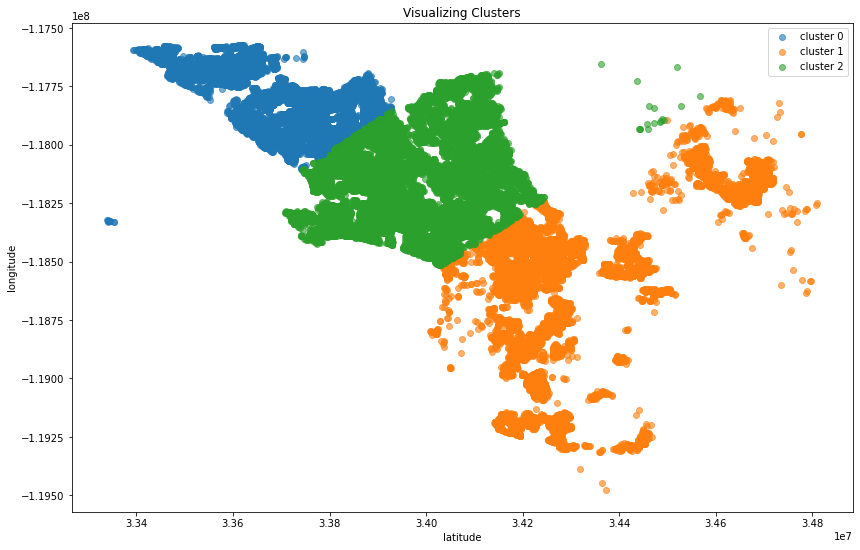

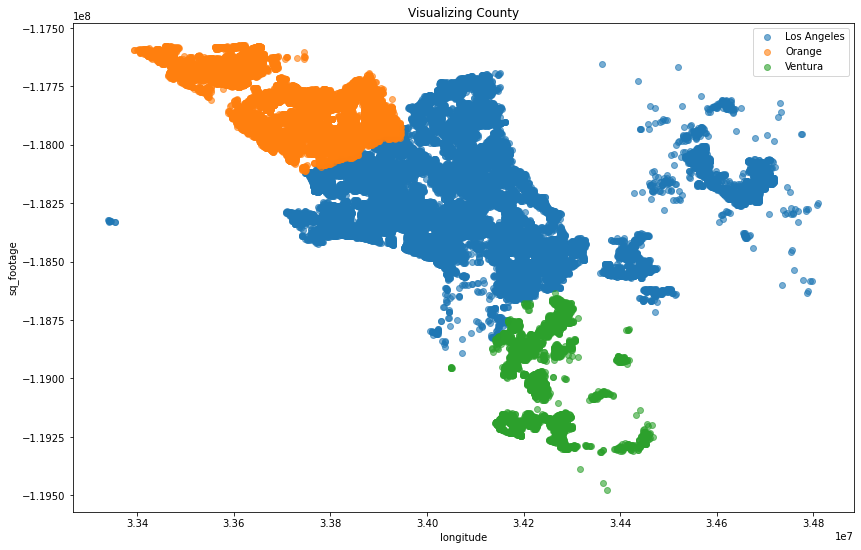

In [69]:
#Visualize the clusters by plotting them 
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Clusters')
plt.show()

#Compare against the actual data by county to compare how the clustering did
plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('county'):
    plt.scatter(subset.latitude, subset.longitude, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('longitude')
plt.ylabel('sq_footage')
plt.title('Visualizing County')
plt.show()

### Clustering Model #2:

In [70]:
# we will create more clusters on the same features using a different k for grouping

X = train[['latitude', 'longitude']]

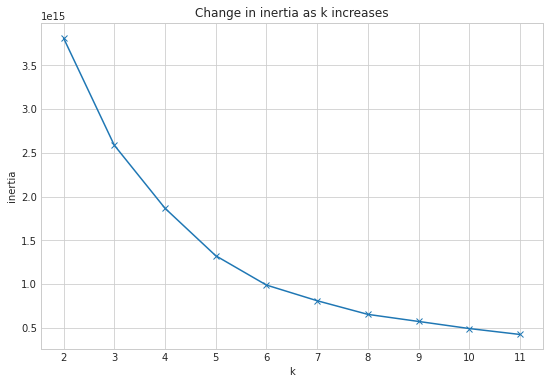

In [71]:
wrangle.inertia_plot(X)

In [72]:
# use the create cluster function from wrangle.py with k value from inertia plot

train, X_scaled_lat_long_k5, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 5)

In [73]:
#Save this clustering for use in independence testing and possible modeling
train['cluster_lat_long_k5'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_long_k5'] = pd.to_numeric(train['cluster_lat_long_k5'],errors='coerce')

#Check to see if it was created
train.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips  \
6378         1.0       3.0                    4.0      1368.0  6037.0   
65133        2.0       4.0                    8.0      2381.0  6037.0   
45602        2.0       3.0                    6.0      1810.0  6037.0   
75623        2.0       4.0                    6.0      1558.0  6059.0   
71792        2.0       4.0                    6.0      1769.0  6111.0   

         latitude    longitude  lotsizesquarefeet  propertylandusetypeid  \
6378   34174813.0 -118512540.0             5899.0                  261.0   
65133  34536607.0 -118049605.0            39349.0                  261.0   
45602  33824560.0 -118270268.0             5604.0                  261.0   
75623  33791770.0 -118068568.0             8255.0                  261.0   
71792  34265339.0 -118798087.0             8090.0                  261.0   

       rawcensustractandblock  ...  transactiondate  heatingorsystemdesc  \
6378             6.037139e+07  ...       2017-01-30           Floor/Wall   
65133            6.037911e+07  ...       2017-08-10              Central   
45602            6.037544e+07  ...       2017-06-13           Floor/Wall   
75623            6.059110e+07  ...       2017-09-12                 None   
71792            6.111008e+07  ...       2017-08-30                 None   

             propertylandusedesc       county  sq_footage_bins  month  \
6378   Single Family Residential  Los Angeles     (1000, 2000]      1   
65133  Single Family Residential  Los Angeles     (2000, 3000]      8   
45602  Single Family Residential  Los Angeles     (1000, 2000]      6   
75623  Single Family Residential       Orange     (1000, 2000]      9   
71792  Single Family Residential      Ventura     (1000, 2000]      8   

       month_bins    cluster  cluster_lat_long  cluster_lat_long_k5  
6378       (0, 3]  cluster_2                 1                    2  
65133      (6, 9]  cluster_0                 1                    0  
45602      (3, 6]  cluster_1                 2                    1  
75623      (6, 9]  cluster_1                 2                    1  
71792      (6, 9]  cluster_4                 1                    4  

[5 rows x 32 columns]

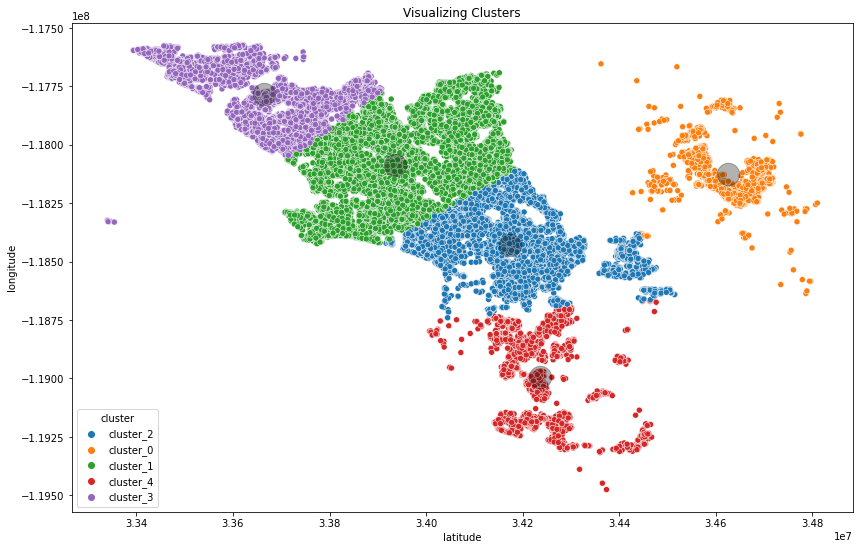

In [74]:
# use the create_scatter_plot function from wrangle.py to plot the data

wrangle.create_scatter_plot('latitude', 'longitude',train,kmeans, X_scaled_lat_long_k5, scaler)

In [75]:
#Even though we only have 3 counties, the grouping by cluster looks good in this model and may be 
#helpful for predicting log error

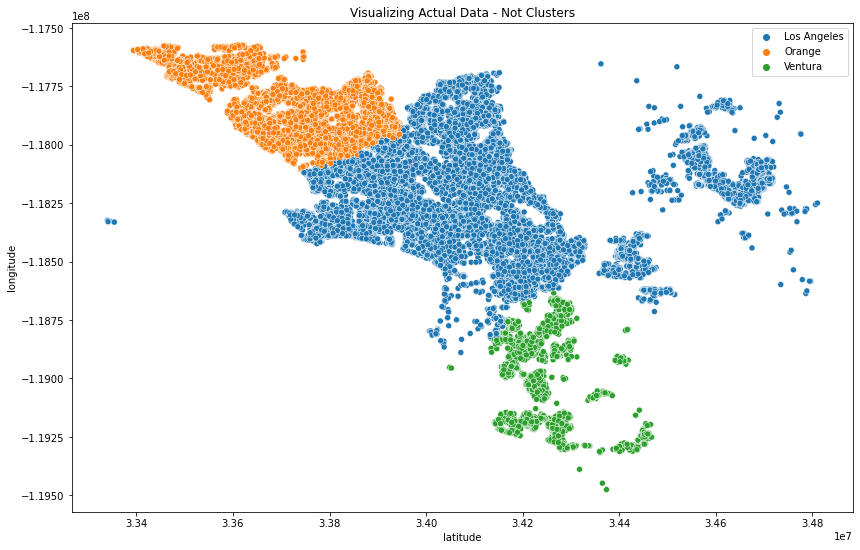

In [76]:
#Compare to actual county boundaries again

wrangle.plot_actual(train, 'county', 'latitude', 'longitude')

### Clustering Model #3:

### Repeat the clustering, this time with 3 different features.¶


In [77]:
# we will create cluster on three features

X = train[['latitude','longitude','sq_footage']]

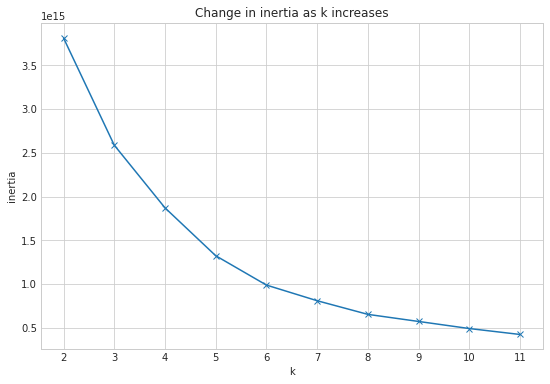

In [78]:
wrangle.inertia_plot(X)

In [79]:
# use the create cluster function from wrangle.py with k value from inertia plot

train, X_scaled_lat_long_sqft, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 5)

In [80]:
#Save this clustering for use in independence testing and possible modeling
train['cluster_lat_long_sqft'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_long_sqft'] = pd.to_numeric(train['cluster_lat_long_sqft'],errors='coerce')

#Check to see if it was created
train.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips  \
6378         1.0       3.0                    4.0      1368.0  6037.0   
65133        2.0       4.0                    8.0      2381.0  6037.0   
45602        2.0       3.0                    6.0      1810.0  6037.0   
75623        2.0       4.0                    6.0      1558.0  6059.0   
71792        2.0       4.0                    6.0      1769.0  6111.0   

         latitude    longitude  lotsizesquarefeet  propertylandusetypeid  \
6378   34174813.0 -118512540.0             5899.0                  261.0   
65133  34536607.0 -118049605.0            39349.0                  261.0   
45602  33824560.0 -118270268.0             5604.0                  261.0   
75623  33791770.0 -118068568.0             8255.0                  261.0   
71792  34265339.0 -118798087.0             8090.0                  261.0   

       rawcensustractandblock  ...  heatingorsystemdesc  \
6378             6.037139e+07  ...           Floor/Wall   
65133            6.037911e+07  ...              Central   
45602            6.037544e+07  ...           Floor/Wall   
75623            6.059110e+07  ...                 None   
71792            6.111008e+07  ...                 None   

             propertylandusedesc       county  sq_footage_bins  month  \
6378   Single Family Residential  Los Angeles     (1000, 2000]      1   
65133  Single Family Residential  Los Angeles     (2000, 3000]      8   
45602  Single Family Residential  Los Angeles     (1000, 2000]      6   
75623  Single Family Residential       Orange     (1000, 2000]      9   
71792  Single Family Residential      Ventura     (1000, 2000]      8   

       month_bins    cluster  cluster_lat_long  cluster_lat_long_k5  \
6378       (0, 3]  cluster_2                 1                    2   
65133      (6, 9]  cluster_0                 1                    0   
45602      (3, 6]  cluster_1                 2                    1   
75623      (6, 9]  cluster_4                 2                    1   
71792      (6, 9]  cluster_2                 1                    4   

       cluster_lat_long_sqft  
6378                       2  
65133                      0  
45602                      1  
75623                      4  
71792                      2  

[5 rows x 33 columns]

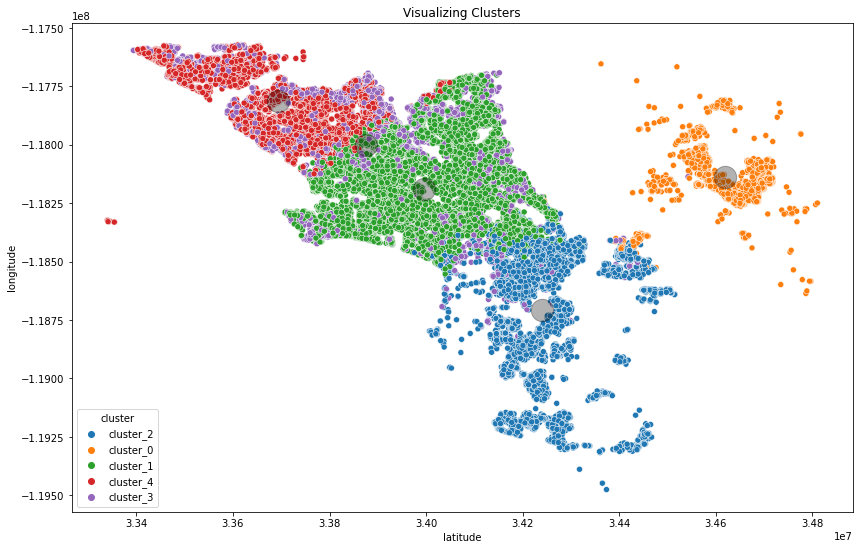

In [81]:
# use the create_scatter_plot function from wrangle.py to plot the cluster data

wrangle.create_scatter_plot('latitude', 'longitude',train,kmeans, X_scaled_lat_long_sqft, scaler)

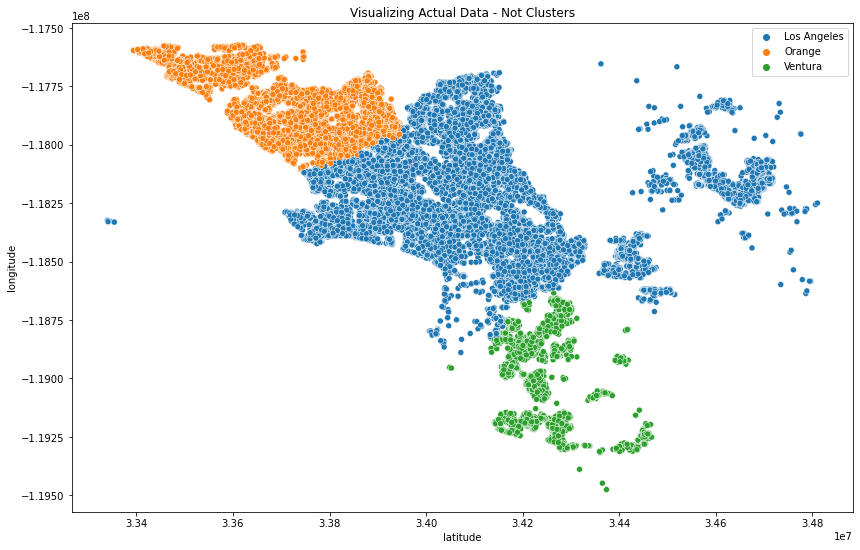

In [82]:
#Compare to actual county boundaries again

wrangle.plot_actual(train, 'county', 'latitude', 'longitude')

In [83]:
#Since we're using 3 features for clustering, the clusters could be mapping to three dimensions and 
#thus why some are overlapping throughout.

### Clustering Model #4:

In [84]:
# we will create cluster on two other separate features
#Using latitude for location and square footage since it ranked high in relation to log error

X = train[['latitude','sq_footage']]

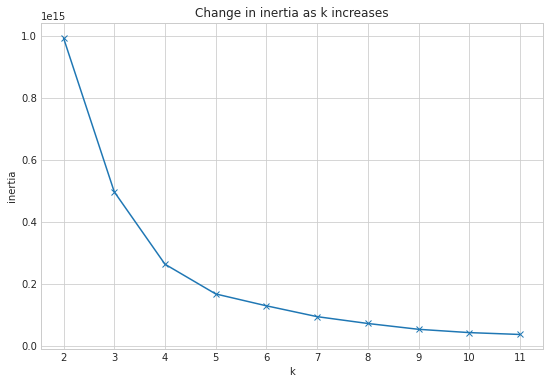

In [85]:
wrangle.inertia_plot(X)

In [86]:
# use the create cluster function from wrangle.py with k value from inertia plot

train, X_scaled_lat_sqft, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 4)

In [87]:
#Save this clustering for use in independence testing and possible modeling
train['cluster_lat_sqft'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_sqft'] = pd.to_numeric(train['cluster_lat_sqft'],errors='coerce')

#Check to see if it was created
train.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips  \
6378         1.0       3.0                    4.0      1368.0  6037.0   
65133        2.0       4.0                    8.0      2381.0  6037.0   
45602        2.0       3.0                    6.0      1810.0  6037.0   
75623        2.0       4.0                    6.0      1558.0  6059.0   
71792        2.0       4.0                    6.0      1769.0  6111.0   

         latitude    longitude  lotsizesquarefeet  propertylandusetypeid  \
6378   34174813.0 -118512540.0             5899.0                  261.0   
65133  34536607.0 -118049605.0            39349.0                  261.0   
45602  33824560.0 -118270268.0             5604.0                  261.0   
75623  33791770.0 -118068568.0             8255.0                  261.0   
71792  34265339.0 -118798087.0             8090.0                  261.0   

       rawcensustractandblock  ...        propertylandusedesc       county  \
6378             6.037139e+07  ...  Single Family Residential  Los Angeles   
65133            6.037911e+07  ...  Single Family Residential  Los Angeles   
45602            6.037544e+07  ...  Single Family Residential  Los Angeles   
75623            6.059110e+07  ...  Single Family Residential       Orange   
71792            6.111008e+07  ...  Single Family Residential      Ventura   

       sq_footage_bins  month  month_bins    cluster  cluster_lat_long  \
6378      (1000, 2000]      1      (0, 3]  cluster_2                 1   
65133     (2000, 3000]      8      (6, 9]  cluster_1                 1   
45602     (1000, 2000]      6      (3, 6]  cluster_0                 2   
75623     (1000, 2000]      9      (6, 9]  cluster_0                 2   
71792     (1000, 2000]      8      (6, 9]  cluster_2                 1   

       cluster_lat_long_k5  cluster_lat_long_sqft  cluster_lat_sqft  
6378                     2                      2                 2  
65133                    0                      0                 1  
45602                    1                      1                 0  
75623                    1                      4                 0  
71792                    4                      2                 2  

[5 rows x 34 columns]

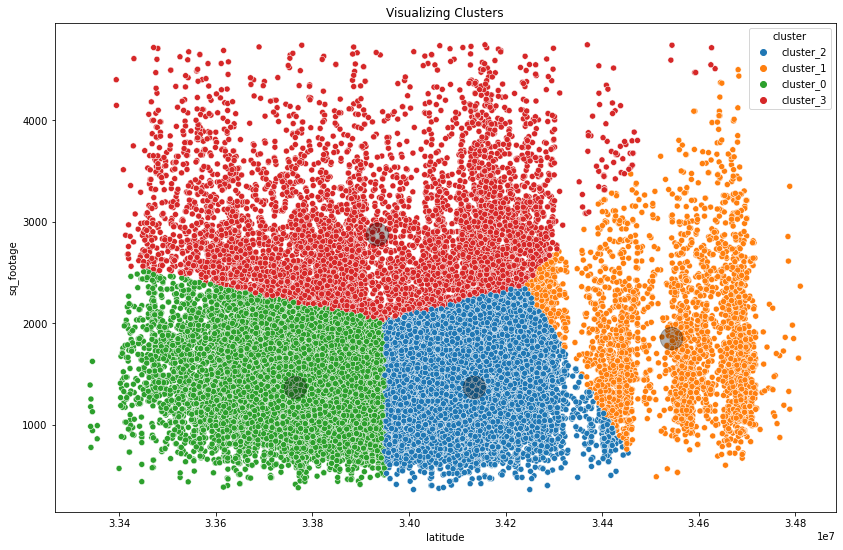

In [88]:
# use the create_scatter_plot function from wrangle.py to plot the cluster data

wrangle.create_scatter_plot('latitude', 'sq_footage',train,kmeans, X_scaled_lat_sqft, scaler)

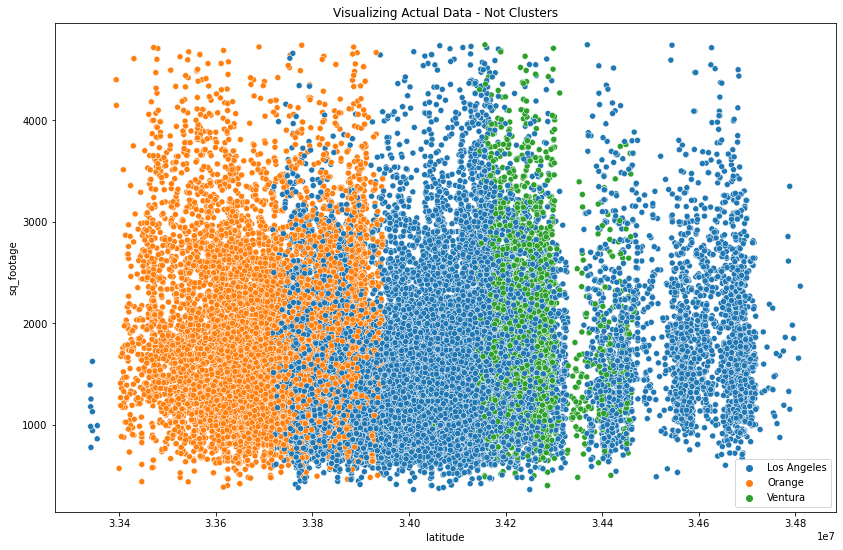

In [89]:
#Compare to actual county boundaries again

wrangle.plot_actual(train, 'county', 'latitude', 'sq_footage')

In [90]:
# Clusters are broken down into 4 groups:

# Cluster_0 - Latitude between about 3.34 - 3.39 and Square Footage up to about 2500 sq ft
# Cluster_1 - Latitude between about 3.42 - 3.48 and Square Footage from about 500 sq ft to up to over 4000 sq ft
# Cluster_2 - Latitude between about 3.39 - 3.45 and Square Footage up to 2500 sq ft
# Cluster_3 - Latitude between about 3.34 - 3.48 and Square Footage over 2000 sq ft

# Clusters do not map clearly to corresponding counties.
# Counties overlap on latitude 
# Most properties seem to be under 3000 sq feet and in Los Angeles county

### Clustering Model #5: 

In [91]:
# we will create cluster on two other separate features
#Using longitude for location and square footage since it ranked high in relation to log error

X = train[['longitude','sq_footage']]

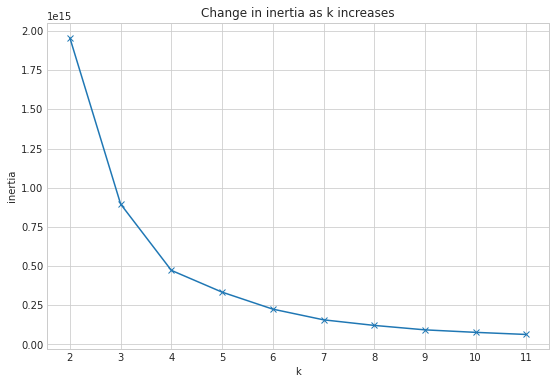

In [92]:
wrangle.inertia_plot(X)

In [93]:
# use the create cluster function from wrangle.py with k value from inertia plot

train, X_scaled_long_sqft, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 4)

In [94]:
#Save this clustering for use in independence testing and possible modeling
train['cluster_long_sqft'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_long_sqft'] = pd.to_numeric(train['cluster_long_sqft'],errors='coerce')

#Check to see if it was created
train.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips  \
6378         1.0       3.0                    4.0      1368.0  6037.0   
65133        2.0       4.0                    8.0      2381.0  6037.0   
45602        2.0       3.0                    6.0      1810.0  6037.0   
75623        2.0       4.0                    6.0      1558.0  6059.0   
71792        2.0       4.0                    6.0      1769.0  6111.0   

         latitude    longitude  lotsizesquarefeet  propertylandusetypeid  \
6378   34174813.0 -118512540.0             5899.0                  261.0   
65133  34536607.0 -118049605.0            39349.0                  261.0   
45602  33824560.0 -118270268.0             5604.0                  261.0   
75623  33791770.0 -118068568.0             8255.0                  261.0   
71792  34265339.0 -118798087.0             8090.0                  261.0   

       rawcensustractandblock  ...       county  sq_footage_bins  month  \
6378             6.037139e+07  ...  Los Angeles     (1000, 2000]      1   
65133            6.037911e+07  ...  Los Angeles     (2000, 3000]      8   
45602            6.037544e+07  ...  Los Angeles     (1000, 2000]      6   
75623            6.059110e+07  ...       Orange     (1000, 2000]      9   
71792            6.111008e+07  ...      Ventura     (1000, 2000]      8   

       month_bins    cluster  cluster_lat_long  cluster_lat_long_k5  \
6378       (0, 3]  cluster_2                 1                    2   
65133      (6, 9]  cluster_1                 1                    0   
45602      (3, 6]  cluster_2                 2                    1   
75623      (6, 9]  cluster_0                 2                    1   
71792      (6, 9]  cluster_3                 1                    4   

       cluster_lat_long_sqft  cluster_lat_sqft  cluster_long_sqft  
6378                       2                 2                  2  
65133                      0                 1                  1  
45602                      1                 0                  2  
75623                      4                 0                  0  
71792                      2                 2                  3  

[5 rows x 35 columns]

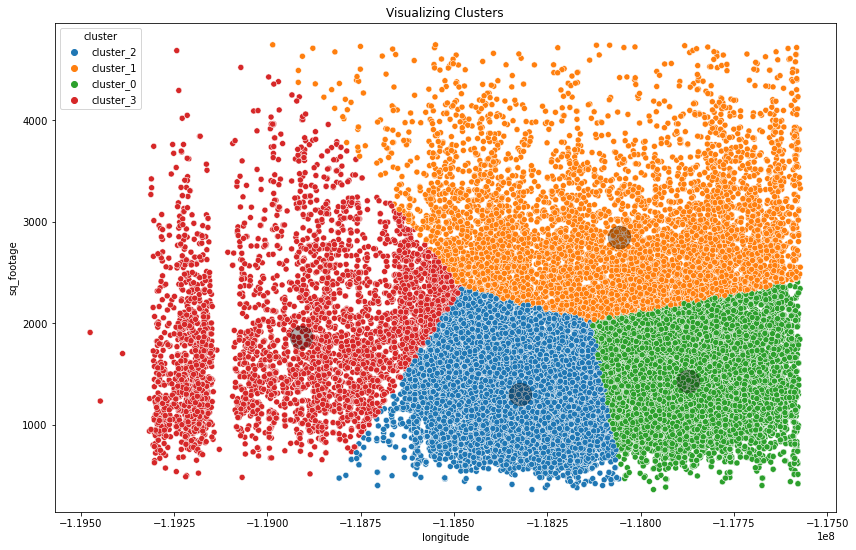

In [95]:
# use the create_scatter_plot function from wrangle.py to plot the cluster data

wrangle.create_scatter_plot('longitude', 'sq_footage',train,kmeans, X_scaled_long_sqft, scaler)

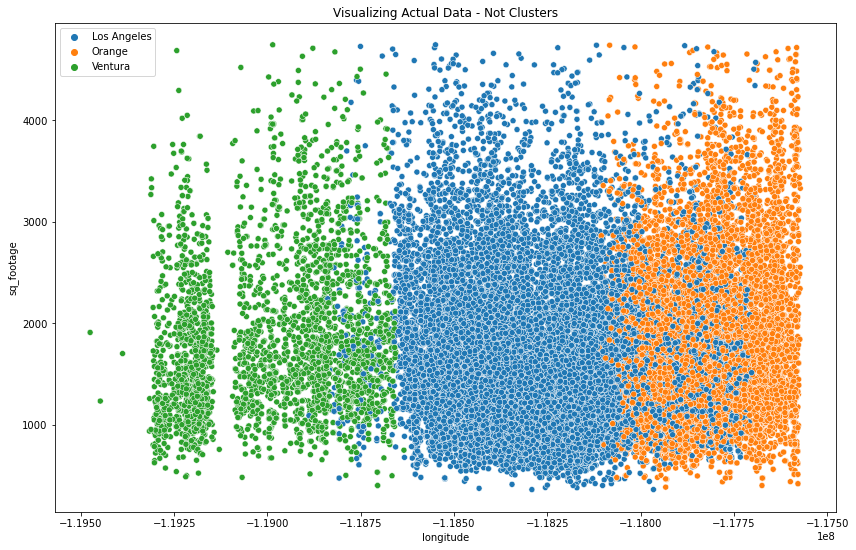

In [96]:
#Compare to actual county boundaries again

wrangle.plot_actual(train, 'county', 'longitude', 'sq_footage')

In [97]:
# Clusters are broken down into 4 groups:

# Cluster_0 - Longitude between about -1.18 thru -1.175 and Square Footage up to about 2000 sq ft
# Cluster_1 - Longitude between about -1.19 thru -1.175 and Square Footage above 2000 sq ft
# Cluster_2 - Longitude between about -1.1875 thru -1.180 and Square Footage up to 2500 sq ft
# Cluster_3 - Longitude between about -1.1950 thru -1.1850 and Square Footage from 500 sq ft to over 4000 sq ft

# Clusters do not map clearly to corresponding counties.
# Counties overlap on longitude 
# Most properties seem to be under 3000 sq feet and in Los Angeles county

# More Hypotheses Testing:

### Hypothesis :

$ Ho $ : Null Hypothesis: There is no correlation between latitude and log error .

$ H \alpha$ : Alternative Hypothesis: Latitude and log error are correlated.

In [98]:
x = train.latitude
y = train.logerror

In [99]:
corr, p = stats.pearsonr(x, y)
corr, p

(-0.011983683714721919, 0.01588690725540967)

In [100]:
# Null hypothesis is rejected.  Latitude and log error are correlated.

### Hypothesis :

$ Ho $ : Null Hypothesis: There is no correlation between longitude and log error .

$ H \alpha$ : Alternative Hypothesis: Longitude and log error are correlated.

In [101]:
x = train.longitude
y = train.logerror

In [102]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.0158791604238391, 0.0013959580658378505)

In [103]:
# Null hypothesis is rejected.  Longitude and log error are correlated.

### Hypothesis :
𝐻𝑜
  : Null Hypothesis: There is no correlation between square footage and log error .

𝐻𝛼
  : Alternative Hypothesis: Square footage and log error are correlated.

In [104]:
x = train.sq_footage
y = train.logerror

In [105]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.036797611550587785, 1.2908358337563422e-13)

In [106]:
# Null hypothesis is rejected.  Square footage and log error are correlated.

### Hypothesis :
𝐻𝑜 : Null Hypothesis: There is no correlation between number of bedrooms and log error .

𝐻𝛼 : Alternative Hypothesis: Number of bedrooms and log error are correlated.

In [107]:
x = train.bedrooms
y = train.logerror

In [108]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.03539232814133619, 1.0479877324586546e-12)

In [109]:
# Null hypothesis is rejected.  Number of bedrooms and log error are correlated.

### Statistical Tests for Independence on Clusters

##### To compare if each cluster is independent of log error, I need to compare the overall log error mean to the mean of each cluster region to see if there is a signifant difference.

- We need to compare the mean of the log error of each one compared to the mean of the log error of all clusters

- Show any differences visually between any clusters of interest and overall mean

### Cluster #1 - Latitude and Longitude 

In [110]:
#Calculating overall log error mean to use for hypothesis testing
logerror_mean =  train.logerror.mean()

logerror_mean

0.01595590245529925

In [111]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance


count = train.cluster_lat_long.max()

i = 0
while i <= count:

        region_mean = train[train.cluster_lat_long == i].logerror.mean()
        
        difference = abs(logerror_mean - region_mean)
    
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
       
        
        region_mean_df.append(
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            },
            ignore_index=True)
              
        print(region_mean_df)      
        
        
        i += 1

   region      mean  difference
0       0  0.020493    0.004537
   region      mean  difference
0       1  0.015784    0.000171
   region      mean  difference
0       2  0.013514    0.002442


In [112]:
# Creating a column with the log error values of cluster 0 since it had the biggest difference to run
# a statistical test  

clust_1_0 = train[train.cluster_lat_long == 0].logerror


#### Clustering Hypothesis #1

$H_0$: There is no relationship between logerror and cluster #1 region #3
    
$H_a$: There is a relationship between logerror and cluster #1 region #3

In [113]:
stats.ttest_ind(train.logerror, clust_1_0)

Ttest_indResult(statistic=-2.4132089758012465, pvalue=0.015816275406814732)

#### We rejected the null hypothesis.  Cluster #1 Region #0 could be used to predict log error. 
***

### Cluster #2 - Latitude and Longitude  with 5 clusters (k = 5)

In [114]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance


count = train.cluster_lat_long_k5.max()

i = 0
while i <= count:

        region_mean = train[train.cluster_lat_long_k5 == i].logerror.mean()
        
        difference = abs(logerror_mean - region_mean)
    
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.017677    0.001721
   region      mean  difference
0       1  0.017528    0.001572
   region      mean  difference
0       2  0.009862    0.006094
   region      mean  difference
0       3  0.020368    0.004412
   region      mean  difference
0       4  0.016449    0.000493


In [115]:
# Creating a column with the log error values of cluster 2 since it had the biggest difference to run
# a statistical test  

clust_2_2 = train[train.cluster_lat_long_k5 == 2].logerror

#### Clustering Hypothesis #2

$H_0$: There is no relationship between logerror and cluster #2 region #2
    
$H_a$: There is a relationship between logerror and cluster #2 region #2

In [116]:
stats.ttest_ind(train.logerror, clust_2_2)

Ttest_indResult(statistic=3.513568273174163, pvalue=0.00044250906968315085)

#### We reject the null hypothesis. Cluster #2 Region #2 can be used to predict log error and beat cluster #1 in pvalue significance.
***

#### Cluster #3 - Latitude and Longitude with Square Footage

In [117]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance


count = train.cluster_lat_long_sqft.max()

i = 0
while i <= count:

        region_mean = train[train.cluster_lat_long_sqft == i].logerror.mean()
        
        difference = abs(logerror_mean - region_mean)
    
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.018431    0.002475
   region      mean  difference
0       1  0.011385    0.004571
   region      mean  difference
0       2  0.014123    0.001833
   region      mean  difference
0       3  0.033391    0.017435
   region      mean  difference
0       4  0.016008    0.000053


In [118]:
# Creating a column with the log error values of cluster 3 since it had the biggest difference to run
# a statistical test  

clust_3_3 = train[train.cluster_lat_long_sqft == 3].logerror


#### Clustering Hypothesis #3

 

$H_0$: There is no relationship between logerror and cluster #3 region #3
    
$H_a$: There is a relationship between logerror and cluster #3 region #3

In [119]:
stats.ttest_ind(train.logerror, clust_3_3)

Ttest_indResult(statistic=-6.69807221645472, pvalue=2.1365110456792645e-11)

#### Cluster #3 rejects the null hypothesis that there is no relationship between log error and cluster #3 region #3. 
This means it can be used to predict log error and it has the lowest pvalue yet which indicates it could be significant.
***

#### Cluster #4 - Latitude and Square Footage 

In [120]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance


count = train.cluster_lat_sqft.max()

i = 0
while i <= count:

        region_mean = train[train.cluster_lat_sqft == i].logerror.mean()
        
        difference = abs(logerror_mean - region_mean)
    
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.015399    0.000557
   region      mean  difference
0       1  0.016441    0.000485
   region      mean  difference
0       2  0.010945     0.00501
   region     mean  difference
0       3  0.03035    0.014394


In [121]:
# Creating a column with the log error values of cluster 3 since it had the biggest difference to run
# a statistical test  

clust_4_3 = train[train.cluster_lat_sqft == 3].logerror


#### Clustering Hypothesis #4

$H_0$: There is no relationship between logerror and cluster #4 region #3
    
$H_a$: There is a relationship between logerror and cluster #4 region #3

In [122]:
stats.ttest_ind(train.logerror, clust_4_3)

Ttest_indResult(statistic=-6.220993169840423, pvalue=4.982020583777617e-10)

#### Cluster #4 Region #3 rejects the null hypothesis that there is no relationship between log error and cluster #4 region #3. 
This means it can be used to predict log error.
***

#### Cluster #5 - Longtitude and Square Footage 

In [123]:
# Looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance


count = train.cluster_long_sqft.max()

i = 0
while i <= count:

        region_mean = train[train.cluster_long_sqft == i].logerror.mean()
        
        difference = abs(logerror_mean - region_mean)
    
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.016864    0.000908
   region      mean  difference
0       1  0.030768    0.014812
   region      mean  difference
0       2  0.009542    0.006414
   region      mean  difference
0       3  0.016101    0.000145


In [124]:
# Creating a column with the log error values of cluster 1 since it had the biggest difference to run
# a statistical test  

clust_5_1 = train[train.cluster_long_sqft == 1].logerror



#### Clustering Hypothesis #5

$H_0$: There is no relationship between logerror and cluster #5 region #1
    
$H_a$: There is a relationship between logerror and cluster #5 region #1

In [125]:
stats.ttest_ind(train.logerror, clust_5_1)

Ttest_indResult(statistic=-6.351417733920599, pvalue=2.152995131824176e-10)

#### Cluster #5 rejects the null hypothesis and thus can be used to predict log error.
***

### Exploration Takeaways:

- Top features correlated to log error are 
    - 1. sq_footage
    - 2. bedrooms
    - 3. bathrooms
- We rejected the null hypothesis that the logerror is the same for all square footages. Log error depends on square footage.
- We rejected the null hypothesis that the logerror is the same for all counties. Log error depends on the county. 
- Orange County has the largest log error, followed by Los Angeles County
- Log error varies by month and by county
- We rejected the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with more than 4 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with more than bedrooms.
- Clustering by latitude and longitude created clusters which mapped to the counties but looked to create an additional cluster which fit the map well. 
- Latitude and longitude independent tests comparing log errors rejected the null hypothesis meaning they are correlated to log error.
- Log error is dependent on square footage and number of bedrooms. 
- Cluster #1 (Latitude/Longitude), #3 (Lat/Long/Square Feet), #4 (Latitude/Square Feet), #5(Longitude/Square Feet) rejected the null hypothesis that there was no relationship between log error so they can be used in modeling.  









# Modeling

In [126]:
#In order to start modeling, we need to create out X and y for train, validate and test

#Set up x and y 
X_train = train[['latitude','longitude','sq_footage','bedrooms', 'bathrooms']]
X_validate = validate[['latitude','longitude','sq_footage','bedrooms', 'bathrooms']] 
X_test = test[['latitude','longitude','sq_footage','bedrooms','bathrooms']] 

y_train = train.logerror
y_validate = validate.logerror
y_test = test.logerror

### Let's look at the Target Variable (y)

This helps us determine which type of algorithm we may want to use.

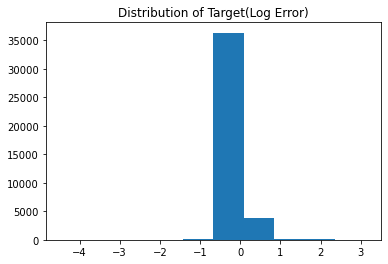

In [127]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(Log Error)')
plt.show()

In [128]:
len(y_train)

40494

In [129]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_train.head()

logerror
6378   0.211513
65133  0.018574
45602  0.017428
75623  0.037663
71792  0.029618

In [130]:
y_validate.head()

logerror
49598  0.002041
37524  0.005851
26688 -0.003732
69378  0.020135
14063 -0.080627

### Feature Engineering¶
Recursive Feature Elimination

- Fits a model and eliminates the worst performing features
- Looks at all the features together

In [131]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1)
rfe.fit(X_train, y_train)
rfe.get_support()

array([False, False, False,  True, False])

In [132]:
X_train.columns[rfe.get_support()]

Index(['bedrooms'], dtype='object')

In [133]:
pd.Series(rfe.ranking_, index=X_train.columns)

latitude      5
longitude     4
sq_footage    3
bedrooms      1
bathrooms     2
dtype: int64

In [134]:
# Number of Bedrooms and Bathrooms were the top features identified with the recursive feature selection.
# Make sure to include those in my model.


### Baseline
About the initial baseline:

Before we begin making models, we need to know how well we can estimate (predict) the final error (logerror) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every error to be the mean error of all the properties in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat.

Predict all errors to be , which is equal to the mean of logerror for the training sample. Store in y_train['logerror_mean'].

Predict all final errors to be , which is equal to the median of logerror for the training sample. Store in y_train['logerror_median'].

Compute the RMSE comparing actual final error (logerror) to logerror_mean.
Compute the RMSE comparing actual final error (logerror) to logerror_median.

In [135]:
# 1. Predict logerror_pred_mean
logerror_pred_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

In [136]:
logerror_pred_mean

0.01595590245529925

In [137]:
# 2. compute price_pred_median
logerror_pred_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

logerror_pred_median

0.00605555060958

In [138]:
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.logerror,
                                y_train.logerror_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** (1/2)

In [139]:
rmse_train_2 = mean_squared_error(y_train.logerror,
                                y_train.logerror_pred_mean, squared = False)
rmse_validate_2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean, squared = False)

In [140]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.16


In [141]:
# 4. RMSE of price_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.16


In [142]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()

# make our first entry into the metric_df with median baseline
metric_df = wrangle.make_metric_df(y_train.logerror,
                           y_train.logerror_pred_median,
                           'median_baseline',
                          metric_df)

In [143]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.164983           0.0

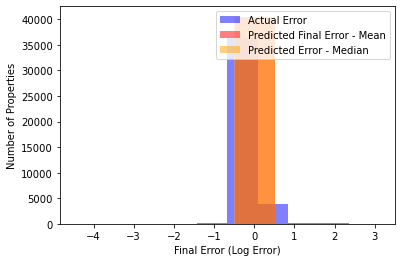

In [144]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.logerror, color='blue', alpha=.5, label="Actual Error")
plt.hist(y_train.logerror_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Error - Mean")
plt.hist(y_train.logerror_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Error - Median")
plt.xlabel("Final Error (Log Error)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

### Linear Regression (OLS)
1. Fit the model using X_train (scaled) and the labels from y_train.
2. Predict final price for properties in training sample using our model (lm).
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.


In [145]:
y_train.head()

logerror  logerror_pred_mean  logerror_pred_median
6378   0.211513            0.015956              0.006056
65133  0.018574            0.015956              0.006056
45602  0.017428            0.015956              0.006056
75623  0.037663            0.015956              0.006056
71792  0.029618            0.015956              0.006056

In [146]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [147]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series 
# 
# fit the thing
# 
lm.fit(X_train, y_train.logerror)

LinearRegression(normalize=True)

In [148]:
# predict train
# 
# use the thing!
# 
y_train['logerror_pred_lm'] = lm.predict(X_train)

In [149]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16453507955273503 
Validation/Out-of-Sample:  0.15956727225155992


In [150]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)

In [151]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.164983      0.000000
1    OLS Regressor       0.159567      0.000402

### LassoLars
1. Fit the model using X_train_scaled and the labels from y_train.
2. Predict final log error for properties in training sample using our model (lars).
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.

In [152]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.16468569272218228 
Validation/Out-of-Sample:  0.15960079545784986


In [153]:
metric_df = wrangle.make_metric_df(y_validate.logerror,
               y_validate.logerror_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [154]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.164983      0.000000
1    OLS Regressor       0.159567      0.000402
2    lasso_alpha_1       0.159601      0.000000

### TweedieRegressor (GLM)
1. Fit the model using X_train_scaled and the labels from y_train.
2. Predict final error for properties in training sample using our model (glm).
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.
5. Compare RMSE train vs. validation. Overfitting?

In [155]:
# create the model object
lars = LassoLars(alpha=4)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** (1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.16468569272218228 
Validation/Out-of-Sample:  0.15960079545784986


In [156]:
metric_df = wrangle.make_metric_df(y_validate.logerror,
               y_validate.logerror_pred_lars,
               'lasso_alpha_4',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.164983      0.000000
1    OLS Regressor       0.159567      0.000402
2    lasso_alpha_1       0.159601      0.000000
3    lasso_alpha_4       0.159601      0.000000

### Polynomial Regression
Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()
1. Create the new features, based on value indicated for degree for train, validate & test.
2. Fit the Linear Regression model
3. Predict using the transformed (squared or cubed, e.g.) features
4. Evaluate using RMSE
5. Repeat predictions and evaluation for validation.
6. Compare RMSE train vs. validation. Overfitting?

### PolynomialFeatures

In [157]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

### LinearRegression¶


In [158]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2) ** (1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16441669038405807 
Validation/Out-of-Sample:  0.15960503829173311


In [159]:
metric_df = wrangle.make_metric_df(y_validate.logerror,
               y_validate.logerror_pred_lm2,
               'quadratic',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       0.164983      0.000000
1    OLS Regressor       0.159567      0.000402
2    lasso_alpha_1       0.159601      0.000000
3    lasso_alpha_4       0.159601      0.000000
4        quadratic       0.159605     -0.000078

In [160]:
# Trying a degree of 3 to check performance

In [161]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 =  pf.transform(X_test)

In [162]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.logerror)

# predict train
y_train['logerror_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3) ** (1/2)

# predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16425534335881725 
Validation/Out-of-Sample:  0.15964344996847785


In [163]:
metric_df = wrangle.make_metric_df(y_validate.logerror,
               y_validate.logerror_pred_lm3,
               '3degree_quadratic',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0    median_baseline       0.164983      0.000000
1      OLS Regressor       0.159567      0.000402
2      lasso_alpha_1       0.159601      0.000000
3      lasso_alpha_4       0.159601      0.000000
4          quadratic       0.159605     -0.000078
5  3degree_quadratic       0.159643     -0.000540

In [164]:
metric_df.style.format(
                formatter={('RMSE_validate', 'r^2_validate'): "{:.5f}",
                          })

In [165]:
# After running different models, choosing OLS Regressor as the best model to use on test.  

### Evaluate
#### Plotting Actual vs. Predicted Values


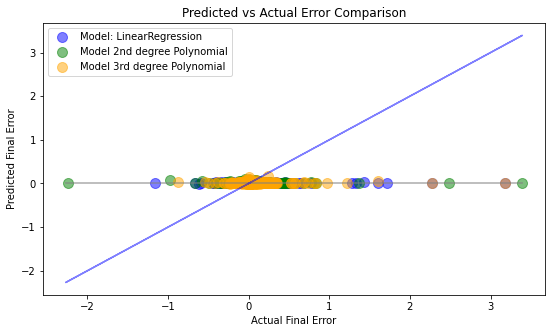

In [166]:
# y_validate.head()
plt.figure(figsize=(9,5))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='_nolegend_')
#plt.annotate("Baseline: Predict Using Mean", (10, 7))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='_nolegend_')
#plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm.sample(n=1000), 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_glm.sample(n=1000), 
            #alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm2.sample(n=1000), 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm3.sample(n=1000), 
            alpha=.5, color="orange", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Error")
plt.ylabel("Predicted Final Error")
plt.title("Predicted vs Actual Error Comparison")
plt.show()

### Residual Plots: Plotting the Errors in Predictions


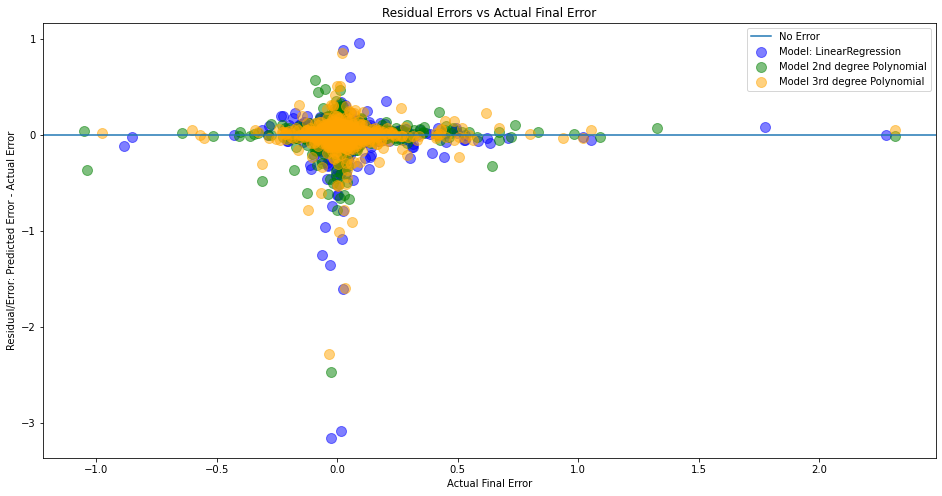

In [167]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
y_lm = y_validate.logerror_pred_lm - y_validate.logerror
#y_glm = y_validate.logerror_pred_glm - y_validate.logerror
y_lm2 = y_validate.logerror_pred_lm2 - y_validate.logerror
y_lm3 = y_validate.logerror_pred_lm3 - y_validate.logerror



plt.scatter(y_validate.logerror.sample(n=1000), y_lm.sample(n=1000) , 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.logerror.sample(n=1000), y_glm.sample(n=1000) , 
            #alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror.sample(n=1000), y_lm2.sample(n=1000) , 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.logerror.sample(n=1000), y_lm3.sample(n=1000) , 
            alpha=.5, color="orange", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Error")
plt.ylabel("Residual/Error: Predicted Error - Actual Error")
plt.title("Residual Errors vs Actual Final Error")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

#### Histograms


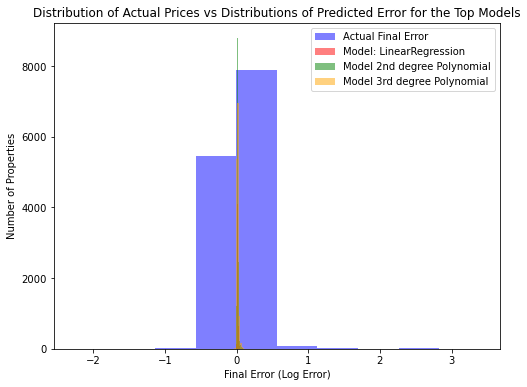

In [168]:
# plot tgo visualize actual vs predicted. 
plt.figure(figsize=(8,6))
plt.hist(y_validate.logerror, color='blue', alpha=.5, label="Actual Final Error")
plt.hist(y_validate.logerror_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
#plt.hist(y_validate.logerror_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.logerror_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.logerror_pred_lm3, color='orange', alpha=.5, label="Model 3rd degree Polynomial")
plt.xlabel("Final Error (Log Error)")
plt.ylabel("Number of Properties")
plt.title("Distribution of Actual Prices vs Distributions of Predicted Error for the Top Models")
plt.legend()
plt.show()


# Modeling Takeaways:

Linear Regression Model performed better than the baseline by having the lowest RMSE and a R^2 of 0.000402. 
Although it performed better than the rest of the models, it does not look to be a significant predictor of error, just barely beating the baseline.  
***

## Run the Model on Test Sample

### Model Selection & Out-of-Sample Evaluation

Model selected: LinearRegression

In [171]:
y_test = pd.DataFrame(y_test)

# predict test
y_test['logerror_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm) ** 0.5


print("RMSE for OLS using Linear Regression Model\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nTest/Out-of-Sample: ", rmse_test)

RMSE for OLS using Linear Regression Model
Training/In-Sample:  0.16453507955273503 
Validation/Out-of-Sample:  0.15956727225155992 
Test/Out-of-Sample:  0.16048899962055183


In [172]:
metric_df = wrangle.make_metric_df(y_test.logerror,
               y_test.logerror_pred_lm,
               'TEST_OLS',
               metric_df)


In [173]:
metric_df.style.format(
                formatter={('RMSE_validate', 'r^2_validate'): "{:.2f}",
                          })

### Final Takeaways:

#### Technical Findings:
- The Ordinary Least Squares (OLS) Linear Regression model performed best on validate and was chosen to be used on 
    unseen, out of sample data
- The Linear Regression model was able to beat the baseline thus possibly reduce log error in actual predictions

#### What Does This Mean to for our Zestimate?
- Our model may be able to reduce log error by 3%
- Features chosen for the model that may be drivers of error include bedrooms, bathrooms, square footage, latitude and longitude
- Even though the model performed slightly better than the baseline, all models seem to indicate that there may not be many significant drivers of log error in this data.


#### Next Steps:

- With more time, I would like to try running models on the clusters since they showed dependency on log error
- I would also like to keep exploring other features and clusters in the models
